In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

This notebook conducts preliminary analysis on data from ATP tennis matches from 2000 to 2019. This data was scraped from https://www.atptour.com/en/scores/results-archive. Each row represents one match, and the winner and loser of the match is included, along with the tournament name, location and start date of the tournament. A total of 64,459 matches were scraped.

We aim to ask some questions of the data:
1. Based on match statistics, can we construct a player ranking that is similar to the ATP rankings?
2. Can we identify future tennis stars early on, based on how they are performing?

### Descriptive Stats
First, we analyse some descriptive stats about the data.

In [2]:
df = pd.read_csv("cleaned/data.csv")
players = df['winner']
players = players.append(df['loser'], ignore_index=True)
players = np.unique(players)
tournaments = np.unique(df['tourney'].map(str))

In [28]:
print("Number of Matches: {}".format(df.shape[0]))
print("Number of Unique players: {}".format(len(players)))
print("Number of Unique tournaments: {}".format(len(tournaments)))

Number of Matches: 64460
Number of Unique players: 2858
Number of Unique tournaments: 177


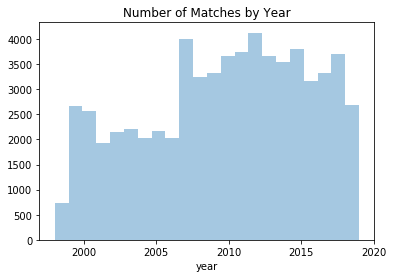

In [50]:
_ = sns.distplot(df['year'].dropna(), hist=True, kde=False, bins=22).set_title("Number of Matches by Year")

From the above plot, we can see that there has been an upward trend of games per year. There are quite few matches in year 1998, perhaps due to incomplete data collection. Therefore, we will drop this year for this analysis. We can try to scrape more data for the final product.

In [51]:
df = df[df.year > 1998]

Next, we look at how many matches each player played, and how many they won or lost.

In [165]:
winners = df.groupby("winner").day.count().reset_index() \
    .rename(columns={"winner": "player", "day":"wins"})
losers = df.groupby("loser").day.count().reset_index() \
    .rename(columns={"loser": "player", "day":"losses"})
df_players = pd.merge(winners, losers, on="player", how="outer") \
    .fillna(0)
df_players['matches'] = df_players['wins'] + df_players['losses']

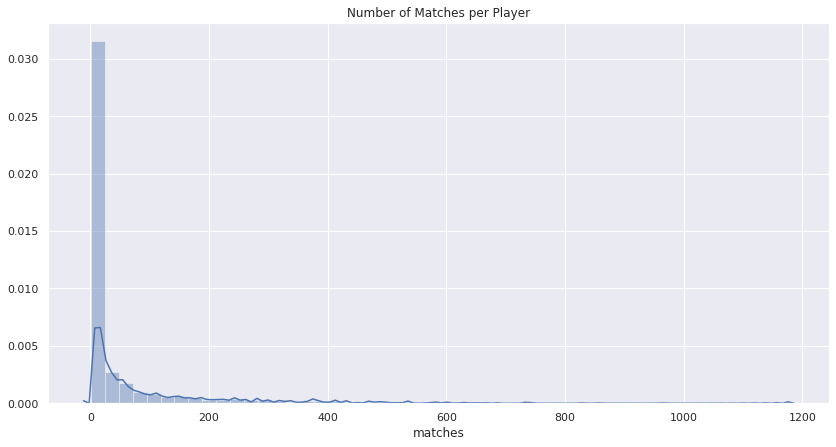

In [166]:
_ = sns.distplot(df_players['matches'].dropna()).set_title("Number of Matches per Player")

We see above that the number of matches follows a power-law distribution. Most players play very few games at the ATP level, presumably because they are not good enough to stay up there. However, some players play a significant number of games (>1000). Hence, let us look at the log plot instead.

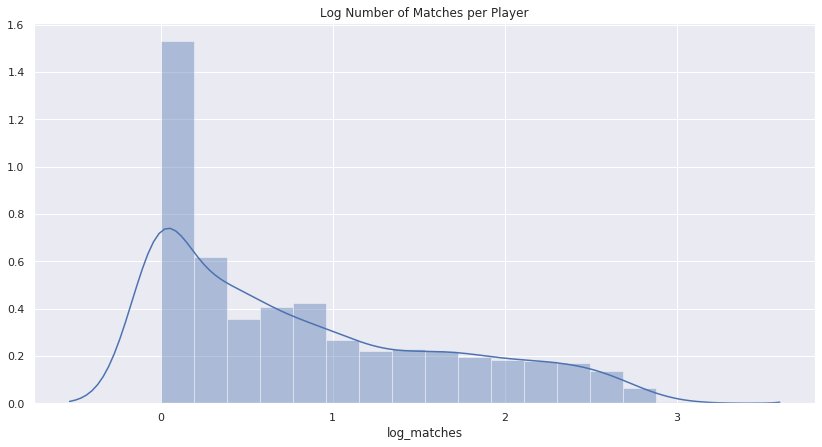

In [167]:
df_players['log_matches'] = np.log10(df_players['matches'])
_ = sns.distplot(df_players['log_matches'].dropna()).set_title("Log Number of Matches per Player")

From the plot, we can see that majority of players actually play less than 10 matches (i.e. 1 on the x-axis). Perhaps around half played more than 10 matches.

In [168]:
# Plotly plot, not visible on gitlab
fig = px.scatter(df_players, x="losses", y="wins", hover_data=['player'])
fig.update_layout(title="Wins vs Losses (by Player)")
fig.show()

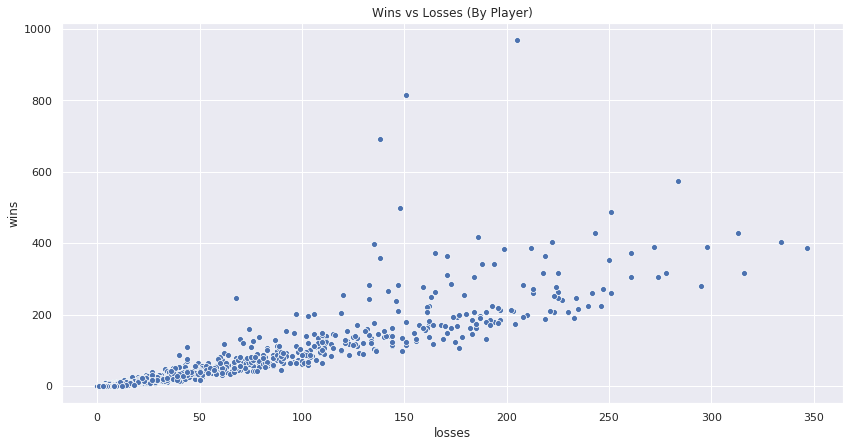

In [169]:
sns.set(rc={'figure.figsize':(14,7)})
_ = sns.scatterplot(data=df_players, x="losses", y="wins").set_title("Wins vs Losses (By Player)")

The plot above shows a scatterplot of each players wins vs losses over this 21 year period. It is interesting that most of them follow an approximately linear trend, with equal numbers of wins and losses. But there are a clear few players who clearly buck the trend and have far more wins than losses. No prizes for guessing who (Federer, Nadal and Djokovic).

Another way to look at this is to analyse win percentage, i.e. number of wins / number of matches. 

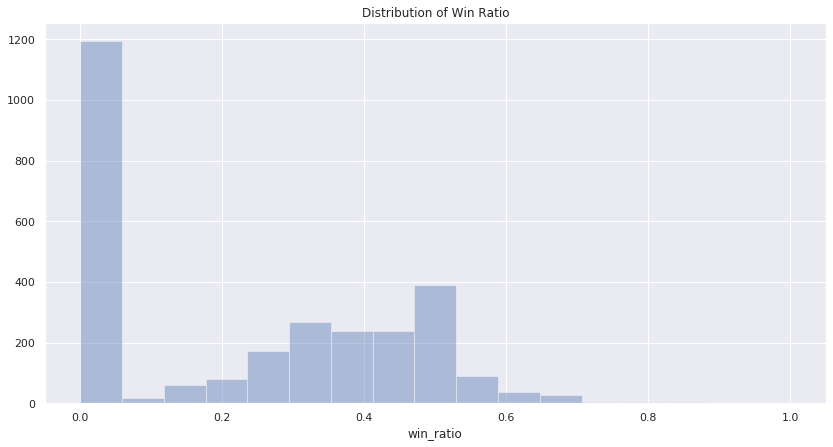

In [170]:
df_players['win_ratio'] = df_players['wins'] / df_players['matches']
_ = sns.distplot(df_players['win_ratio'].dropna(), kde=False).set_title("Distribution of Win Ratio")

From the above, we observe a few things:  
- There is a mode of players with 0% win ratio. These are likely players who only played a few matches and lost all of them.
- There is a second mode of players with around 50% win ratio. This is interesting, because it means that the player seeding system is working well, such that players are matched with players of roughly the same standard, such that players only win 50% of their games.
- There are very few with above 60% win ratio - these are the best players.

### Ranking
As we see above, the most crude measure of player ranking is win/loss ratio. We can use this idea to construct a measure of the best players in each year, and see how it lines up with reality. To avoid anomalies, we filter for players with at least 10 matches in a given year.

In [116]:
winners = df.groupby(["winner", "year"]).day.count().reset_index() \
    .rename(columns={"winner": "player", "day":"wins"})
losers = df.groupby(["loser", "year"]).day.count().reset_index() \
    .rename(columns={"loser": "player", "day":"losses"})
df_players = pd.merge(winners, losers, on=["player", "year"], how="outer") \
    .fillna(0)
df_players['matches'] = df_players['wins'] + df_players['losses']
df_players['win_ratio'] = df_players['wins'] / df_players['matches']
df_players = df_players[df_players['matches'] > 10]

Here, we collect all the top players in each year and see how they performed over the years.

In [161]:
def get_top_player(yr):
    temp = df_players[df_players.year == yr]
    temp = temp.sort_values("win_ratio", ascending=False).reset_index()
    return temp.loc[0, 'player']

top_players = set()
for yr in range(1999, 2020, 1):
    print(str(yr) + ": " + get_top_player(yr))
    top_players.add(get_top_player(yr))
top_players = list(top_players)

1999: Andre Agassi
2000: Gustavo Kuerten
2001: Andre Agassi
2002: Lleyton Hewitt
2003: Andre Agassi
2004: Roger Federer
2005: Roger Federer
2006: Roger Federer
2007: Roger Federer
2008: Rafael Nadal
2009: Roger Federer
2010: Rafael Nadal
2011: Novak Djokovic
2012: Roger Federer
2013: Rafael Nadal
2014: Novak Djokovic
2015: Novak Djokovic
2016: Novak Djokovic
2017: Roger Federer
2018: Rafael Nadal
2019: Rafael Nadal


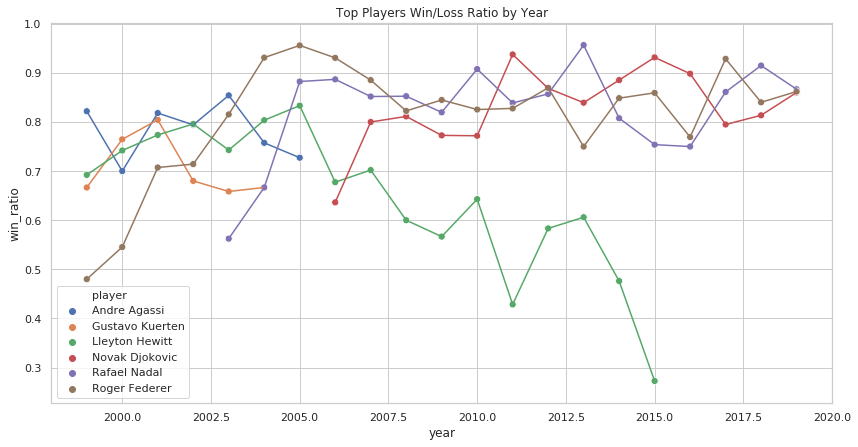

In [163]:
sns.set(rc={'figure.figsize':(14,7)})
sns.set_style("whitegrid")
top_players_df = df_players[df_players['player'].isin(top_players)]
_ = sns.scatterplot(data=top_players_df, x="year", y="win_ratio", hue="player", s=50) \
    .set_title("Top Players Win/Loss Ratio by Year")
_ = sns.lineplot(data=top_players_df, x="year", y="win_ratio", hue="player", legend=False)

The above plot shows some interesting trends. For example, we can clearly see Lleyton Hewitt falling out of favour starting from year 2005. We can also see the respective starting year of Federer (2000), Nadal (2003) and Djokovic (2006) before their meteoric rise. We can also observe which years are the peak years of each player.

With the above analysis, we have some confidence that the data we have is helpful for the analysis project that we aim to do. The goal is to next build some predictive models to see if we can predict top players ahead of time, as well as to provide an interactive website for fans to interact with these findings for their favourite players.